## Loading the python packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load libraries
import os
import alpaca_trade_api as tradeapi
import numpy as np
import pandas as pd
from datetime import datetime
from pandas_datareader import data

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

Next, we extract the data required for our analysis using pandas datareader. 

In [4]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [5]:
# Set the Tesla tickers
ticker = ["TSLA"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2013-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-08-01", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for Tesla and Coca-Cola
df_ticker = alpaca.get_barset(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Display sample data
df_ticker.count()

TSLA  open      1000
      high      1000
      low       1000
      close     1000
      volume    1000
dtype: int64

In [6]:
# shape of the data
df_ticker.shape

(1000, 5)

## Data Preparation

In [7]:
stock_data = df_ticker.loc[:,'TSLA']
stock_data.head()

,open,high,low,close,volume
2017-08-10 00:00:00-04:00,362.00,366.6504,354.66,355.40,5778816
2017-08-11 00:00:00-04:00,356.97,361.2600,353.62,357.87,3447797
2017-08-14 00:00:00-04:00,364.63,367.6600,362.60,363.80,3538601
2017-08-15 00:00:00-04:00,365.20,365.4900,359.37,362.23,2333895
2017-08-16 00:00:00-04:00,363.00,366.5000,362.52,362.91,2514861


In [8]:
#Checking for null values and removing the null values if any
print('Null Values =',stock_data.isnull().values.any())

Null Values = False


## Feature Engineering - Create Signals

Our approach is based on price momentum. We will derive momentum fatures that will be used to predict future signals.

The current Data consists of date, open, high, low, close and volume. Following momentum indicator based signals derived using this data. 
* **Exponential Moving Average Cross-over signal of closing prices**   
* **Daily Return Volatility signal** 
* **Relative Strength Index(RSI)** : a momentum indicator that measures the magnitude of recent price changes and indicates if the stock is overbought or oversold. 
* **Rate Of Change(ROC)**: a momentum oscillator that measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : measure the speed at which the price is changing.

In [9]:
# Drop NA and calculate daily returns
stock_data['daily_return'] = stock_data['close'].pct_change()
stock_data.head()

,open,high,low,close,volume,daily_return
2017-08-10 00:00:00-04:00,362.00,366.6504,354.66,355.40,5778816,NaN
2017-08-11 00:00:00-04:00,356.97,361.2600,353.62,357.87,3447797,0.006950
2017-08-14 00:00:00-04:00,364.63,367.6600,362.60,363.80,3538601,0.016570
2017-08-15 00:00:00-04:00,365.20,365.4900,359.37,362.23,2333895,-0.004316
2017-08-16 00:00:00-04:00,363.00,366.5000,362.52,362.91,2514861,0.001877


## Construct Trading Signals (Features)

In [34]:
#Technical indicators and related signals are implemented inside the module 'ta'
from ta import ema_crossover_signal, vol_signal, bollinger_band_signal, rate_of_change_signal, momentum_signal, rsi_signal, \
               stok_signal, stod_signal

In [12]:
# Set short and long windows
short_window = 10
long_window = 30

#### Trading Signal - Feature 1 : Construct Exponentrial Moving Average Cross-over of Closing Prices

In [13]:
# Call EMA_crossover_signal() in the module 'ta' to derive EMA crossover signal
stock_data[['fast_close','slow_close','crossover_signal']] = ema_crossover_signal(stock_data,short_window,long_window)
stock_data.tail(2)

,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_signal
2021-07-29 00:00:00-04:00,650.07,683.69,648.8,677.36,28853702,0.046973,651.814489,656.452949,-1.0
2021-07-30 00:00:00-04:00,671.75,697.53,669.0,687.60,27669216,0.015118,654.210937,657.164349,-1.0


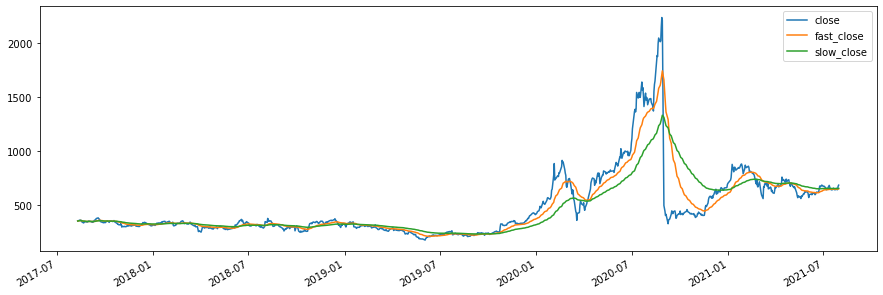

In [14]:
# Plot the EMA of closing prices
stock_data[['close', 'fast_close', 'slow_close']].plot(figsize=(15,5))

#### Trading Signal - Feature 2: Construct Exponential Moving Average of Daily Return Volatility 

In [15]:
# Call vol_signal() in the module 'ta' to derive Daily Return Volatility crossover signal
stock_data[['fast_vol','slow_vol','vol_trend_signal']] = vol_signal(stock_data, short_window, long_window)
stock_data.tail(2)

,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_signal,fast_vol,slow_vol,vol_trend_signal
2021-07-29 00:00:00-04:00,650.07,683.69,648.8,677.36,28853702,0.046973,651.814489,656.452949,-1.0,0.022767,0.030262,1.0
2021-07-30 00:00:00-04:00,671.75,697.53,669.0,687.60,27669216,0.015118,654.210937,657.164349,-1.0,0.022204,0.029986,1.0


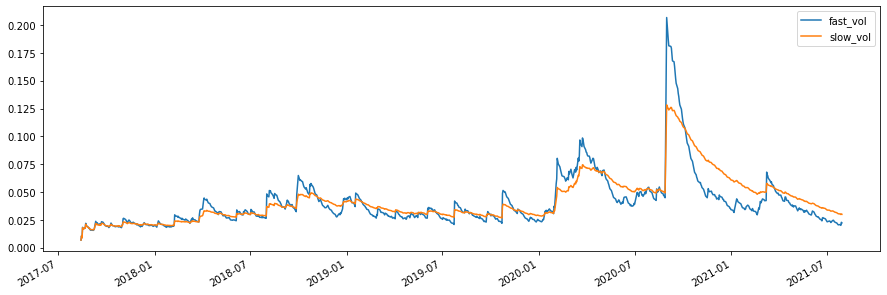

In [16]:
# Plot Daily Return Volatility
stock_data[['fast_vol', 'slow_vol']].plot(figsize=(15,5))

#### Trading Signal - Feature 3: Construct Bollinger Band

In [17]:
# Set bollinger band window
bollinger_window = 20

# call bollinger_band() in 'ta' module to calculate signal from Bollinger Band
stock_data[['bollinger_mid_band','bollinger_upper_band','bollinger_lower_band','bollinger_signal']] = bollinger_band_signal(stock_data,bollinger_window)

stock_data.tail(2)

,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_signal,fast_vol,slow_vol,vol_trend_signal,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_signal
2021-07-29 00:00:00-04:00,650.07,683.69,648.8,677.36,28853702,0.046973,651.814489,656.452949,-1.0,0.022767,0.030262,1.0,657.797655,670.950655,644.644655,-1.0
2021-07-30 00:00:00-04:00,671.75,697.53,669.0,687.60,27669216,0.015118,654.210937,657.164349,-1.0,0.022204,0.029986,1.0,658.281655,672.359657,644.203653,-1.0


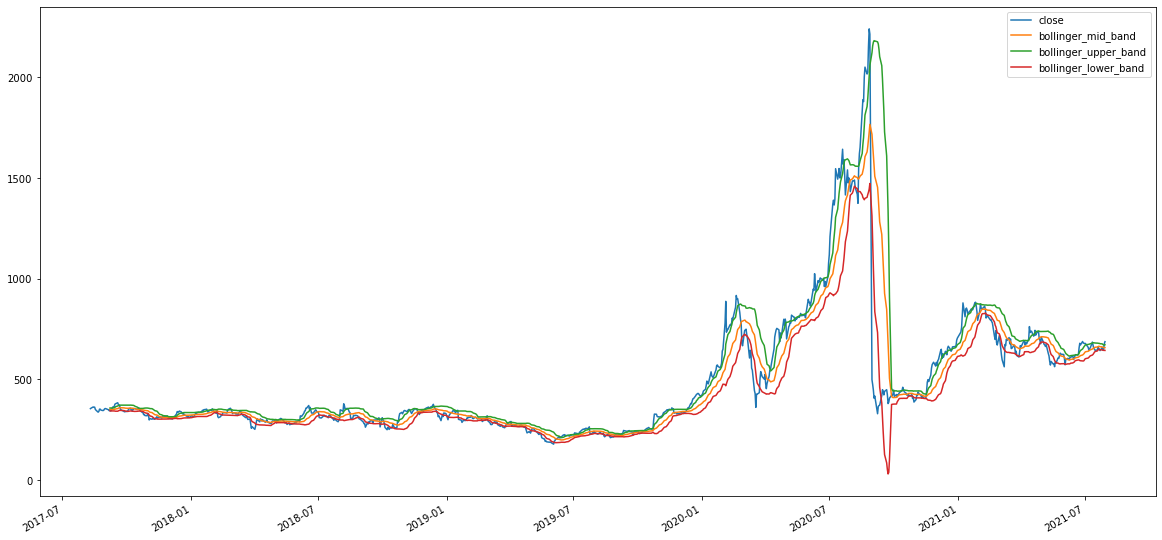

In [18]:
# Plot the Bollinger Bands for the closing prices
stock_data[['close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

#### Trading Signal - Feature 4: Construct Rate-Of_change for the closing prices

In [20]:
stock_data[['fast_roc','slow_roc','roc_trend_signal']] = rate_of_change_signal(stock_data,short_window,long_window)
stock_data.tail(2)

,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_signal,fast_vol,slow_vol,vol_trend_signal,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_signal,fast_roc,slow_roc,roc_trend_signal
2021-07-29 00:00:00-04:00,650.07,683.69,648.8,677.36,28853702,0.046973,651.814489,656.452949,-1.0,0.022767,0.030262,1.0,657.797655,670.950655,644.644655,-1.0,5.176858,9.854038,1.0
2021-07-30 00:00:00-04:00,671.75,697.53,669.0,687.60,27669216,0.015118,654.210937,657.164349,-1.0,0.022204,0.029986,1.0,658.281655,672.359657,644.203653,-1.0,6.372117,10.312520,1.0


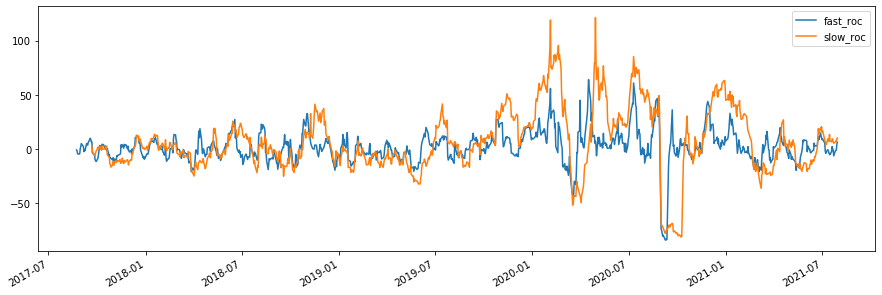

In [22]:
# Plot Rate-Of_change of closing prices
stock_data[['fast_roc', 'slow_roc']].plot(figsize=(15,5))

#### Trading Signal - Feature 5: Construct Momentum for the closing prices

In [26]:
stock_data[['fast_mom','slow_mom','mom_trend_signal']] = momentum_signal(stock_data,short_window,long_window)
stock_data.tail(2)

,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_signal,fast_vol,...,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_signal,fast_roc,slow_roc,roc_trend_signal,fast_mom,slow_mom,mom_trend_signal
2021-07-29 00:00:00-04:00,650.07,683.69,648.8,677.36,28853702,0.046973,651.814489,656.452949,-1.0,0.022767,...,657.797655,670.950655,644.644655,-1.0,5.176858,9.854038,1.0,26.44,72.57,1.0
2021-07-30 00:00:00-04:00,671.75,697.53,669.0,687.60,27669216,0.015118,654.210937,657.164349,-1.0,0.022204,...,658.281655,672.359657,644.203653,-1.0,6.372117,10.312520,1.0,43.58,71.00,1.0


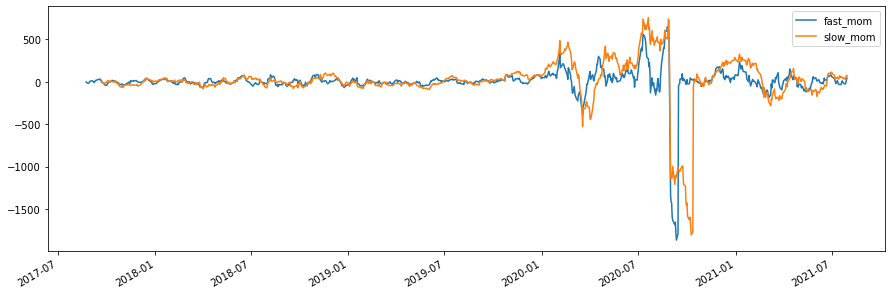

In [27]:
# Plot momentum of closing prices
stock_data[['fast_mom', 'slow_mom']].plot(figsize=(15,5))

#### Trading Signal - Feature 6: Construct RSI signal for the closing prices

In [31]:
stock_data[['fast_rsi','slow_rsi','rsi_trend_signal']] = rsi_signal(stock_data,short_window,long_window)
stock_data.tail(2)

,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_signal,fast_vol,...,bollinger_signal,fast_roc,slow_roc,roc_trend_signal,fast_mom,slow_mom,mom_trend_signal,fast_rsi,slow_rsi,rsi_trend_signal
2021-07-29 00:00:00-04:00,650.07,683.69,648.8,677.36,28853702,0.046973,651.814489,656.452949,-1.0,0.022767,...,-1.0,5.176858,9.854038,1.0,26.44,72.57,1.0,61.103244,53.574051,-1.0
2021-07-30 00:00:00-04:00,671.75,697.53,669.0,687.60,27669216,0.015118,654.210937,657.164349,-1.0,0.022204,...,-1.0,6.372117,10.312520,1.0,43.58,71.00,1.0,64.609387,54.836783,-1.0


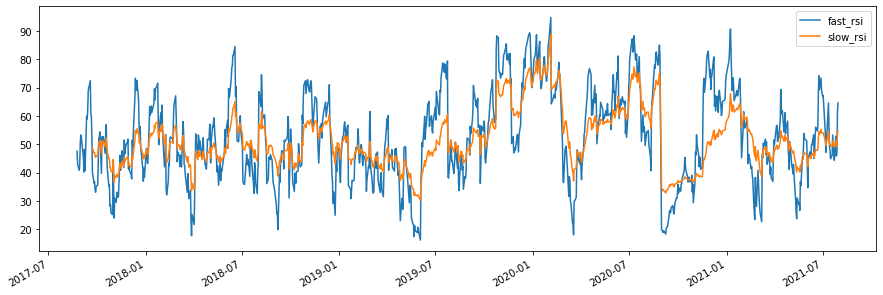

In [32]:
# Plot rsi 
stock_data[['fast_rsi', 'slow_rsi']].plot(figsize=(15,5))

#### Trading Signal - Feature 7: Construct Fast Stochastic Osillator (STOK) signal

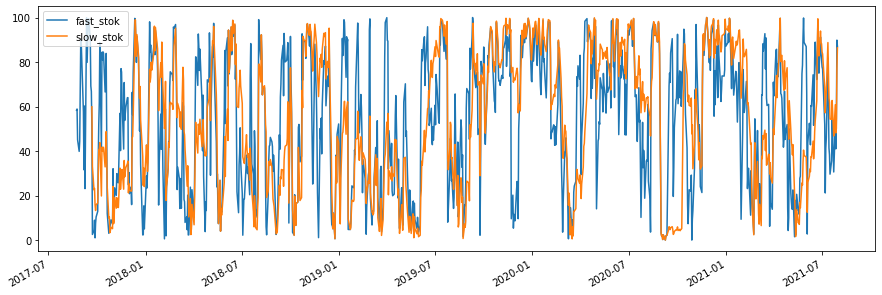

In [37]:
# Plot stochastic osillator - STOK
stock_data[['fast_stok', 'slow_stok']].plot(figsize=(15,5))

#### Trading Signal - Feature 8: Construct Slow Stochastic Osillator (STOD) signal

In [39]:
stock_data[['fast_stod','slow_stod','stod_trend_signal']] = stod_signal(stock_data,short_window,long_window)
stock_data.tail(2)

,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_signal,fast_vol,...,mom_trend_signal,fast_rsi,slow_rsi,rsi_trend_signal,fast_stok,slow_stok,stok_trend_signal,fast_stod,slow_stod,stod_trend_signal
2021-07-29 00:00:00-04:00,650.07,683.69,648.8,677.36,28853702,0.046973,651.814489,656.452949,-1.0,0.022767,...,1.0,61.103244,53.574051,-1.0,89.855769,77.052504,-1.0,47.396748,69.043798,1.0
2021-07-30 00:00:00-04:00,671.75,697.53,669.0,687.60,27669216,0.015118,654.210937,657.164349,-1.0,0.022204,...,1.0,64.609387,54.836783,-1.0,86.975341,86.391572,-1.0,53.132250,70.300900,1.0


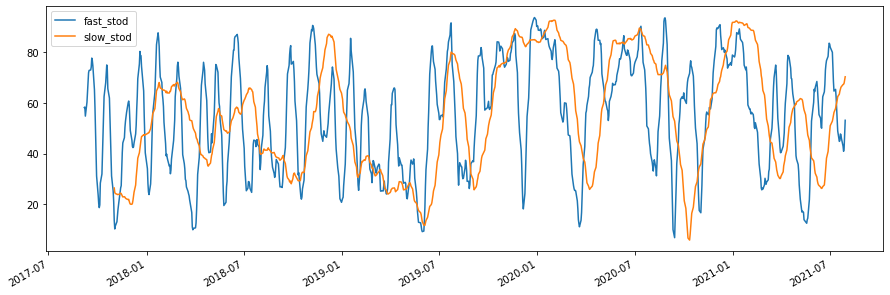

In [40]:
# Plot stochastic osillator - STOD
stock_data[['fast_stod', 'slow_stod']].plot(figsize=(15,5))

In [42]:
#excluding columns that are not needed for our prediction.
stock_data=stock_data.drop(['high','low','open', 'close', 'volume','fast_close','slow_close','fast_vol','slow_vol',
                           'bollinger_mid_band','bollinger_upper_band','bollinger_lower_band',
                           'fast_roc','slow_roc','fast_mom','slow_mom','fast_rsi','slow_rsi',
                           'fast_stok','slow_stok','fast_stod','slow_stod'], axis=1)

In [53]:
# Drop NAs and replace positive/negative infinity values
stock_data.dropna(inplace=True)
stock_data = stock_data.replace([np.inf, -np.inf], np.nan)
stock_data.head()

,daily_return,crossover_signal,vol_trend_signal,bollinger_signal,roc_trend_signal,mom_trend_signal,rsi_trend_signal,stok_trend_signal,stod_trend_signal
2017-08-24 00:00:00-04:00,0.000539,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-25 00:00:00-04:00,-0.014025,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-28 00:00:00-04:00,-0.006696,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-29 00:00:00-04:00,0.004571,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-30 00:00:00-04:00,0.016962,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
trading_signals_df = stock_data.copy()
trading_signals_df.tail(2)

,daily_return,crossover_signal,vol_trend_signal,bollinger_signal,roc_trend_signal,mom_trend_signal,rsi_trend_signal,stok_trend_signal,stod_trend_signal
2021-07-29 00:00:00-04:00,0.046973,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0
2021-07-30 00:00:00-04:00,0.015118,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0


### Set X-Variable List and Filter to Obtain Associated Values

In [56]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal','roc_trend_signal','mom_trend_signal','rsi_trend_signal',
             'stok_trend_signal','stod_trend_signal']

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,roc_trend_signal,mom_trend_signal,rsi_trend_signal,stok_trend_signal,stod_trend_signal
2021-07-26 00:00:00-04:00,-1.0,1.0,0.0,1.0,1.0,-1.0,1.0,1.0
2021-07-27 00:00:00-04:00,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-07-28 00:00:00-04:00,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0
2021-07-29 00:00:00-04:00,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0
2021-07-30 00:00:00-04:00,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0


### Shift the DataFrame Index by 1

In [57]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,roc_trend_signal,mom_trend_signal,rsi_trend_signal,stok_trend_signal,stod_trend_signal
2021-07-26 00:00:00-04:00,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-07-27 00:00:00-04:00,-1.0,1.0,0.0,1.0,1.0,-1.0,1.0,1.0
2021-07-28 00:00:00-04:00,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-07-29 00:00:00-04:00,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0
2021-07-30 00:00:00-04:00,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0


### Construct the Dependent Variable

In [82]:
# Drop NAs and replace positive/negative infinity values
trading_signals_df.dropna(subset=x_var_list, inplace=True)
trading_signals_df.dropna(subset=['daily_return'], inplace=True)
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)
trading_signals_df.head()

,daily_return,crossover_signal,vol_trend_signal,bollinger_signal,roc_trend_signal,mom_trend_signal,rsi_trend_signal,stok_trend_signal,stod_trend_signal,Positive Return
2017-08-25 00:00:00-04:00,-0.014025,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-28 00:00:00-04:00,-0.006696,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-29 00:00:00-04:00,0.004571,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-08-30 00:00:00-04:00,0.016962,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-08-31 00:00:00-04:00,0.007816,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [83]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
trading_signals_df['Positive Return'] = np.where(trading_signals_df['daily_return'] > 0, 1.0, 0.0)
trading_signals_df.tail(2)

,daily_return,crossover_signal,vol_trend_signal,bollinger_signal,roc_trend_signal,mom_trend_signal,rsi_trend_signal,stok_trend_signal,stod_trend_signal,Positive Return
2021-07-29 00:00:00-04:00,0.046973,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0,1.0
2021-07-30 00:00:00-04:00,0.015118,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0


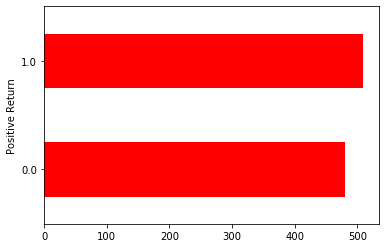

In [84]:
fig = plt.figure()
plot = trading_signals_df.groupby(['Positive Return']).size().plot(kind='barh', color='red')
plt.show()

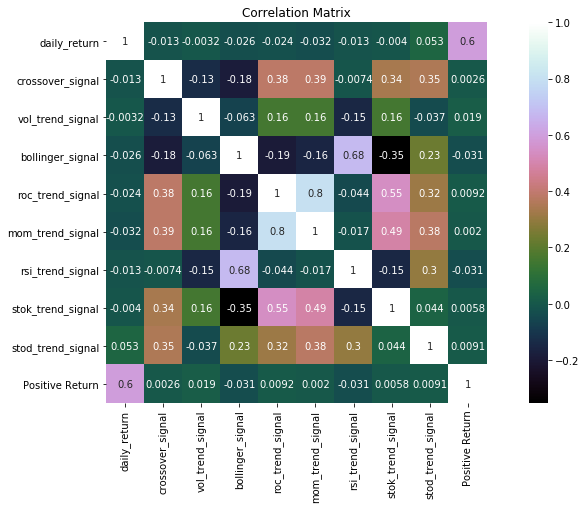

In [85]:
# correlation
correlation = trading_signals_df.corr()
plt.figure(figsize=(15,7))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

### Assign Training and Testing Windows

In [86]:
# Construct training start and end dates
training_start = trading_signals_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-06-30'

# Construct testing start and end dates
testing_start =  '2020-07-01'
testing_end = trading_signals_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2017-08-25
Training End: 2020-06-30
Testing Start: 2020-07-01
Testing End: 2021-07-30


### Separate X and y Training Datasets

In [87]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df['Positive Return'][training_start:training_end]

X_train.tail(2)

,crossover_signal,vol_trend_signal,bollinger_signal,roc_trend_signal,mom_trend_signal,rsi_trend_signal,stok_trend_signal,stod_trend_signal
2020-06-29 00:00:00-04:00,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2020-06-30 00:00:00-04:00,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0


In [88]:
y_train.tail()

2020-06-24 00:00:00-04:00    0.0
2020-06-25 00:00:00-04:00    1.0
2020-06-26 00:00:00-04:00    0.0
2020-06-29 00:00:00-04:00    1.0
2020-06-30 00:00:00-04:00    1.0
Name: Positive Return, dtype: float64

### Separate X and y Testing Datasets

In [89]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df['Positive Return'][testing_start:testing_end]

X_test.tail(2)

,crossover_signal,vol_trend_signal,bollinger_signal,roc_trend_signal,mom_trend_signal,rsi_trend_signal,stok_trend_signal,stod_trend_signal
2021-07-29 00:00:00-04:00,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0
2021-07-30 00:00:00-04:00,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0


In [90]:
y_test.tail()

2021-07-26 00:00:00-04:00    1.0
2021-07-27 00:00:00-04:00    0.0
2021-07-28 00:00:00-04:00    1.0
2021-07-29 00:00:00-04:00    1.0
2021-07-30 00:00:00-04:00    1.0
Name: Positive Return, dtype: float64

# Model training and evaluation

In [91]:
# evaluation metrics for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring = 'roc_auc'

## Models

In [92]:
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

#Neural Network
models.append(('NN', MLPClassifier()))

#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [93]:
models

[('LR', LogisticRegression(n_jobs=-1)),
 ('KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier()),
 ('NN', MLPClassifier()),
 ('AB', AdaBoostClassifier()),
 ('GBM', GradientBoostingClassifier()),
 ('RF', RandomForestClassifier(n_jobs=-1))]

In [94]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.487539 (0.027928)
KNN: 0.542097 (0.069306)
CART: 0.533744 (0.056215)
NN: 0.537715 (0.033652)
AB: 0.472046 (0.056051)
GBM: 0.543525 (0.051895)
RF: 0.532218 (0.061409)


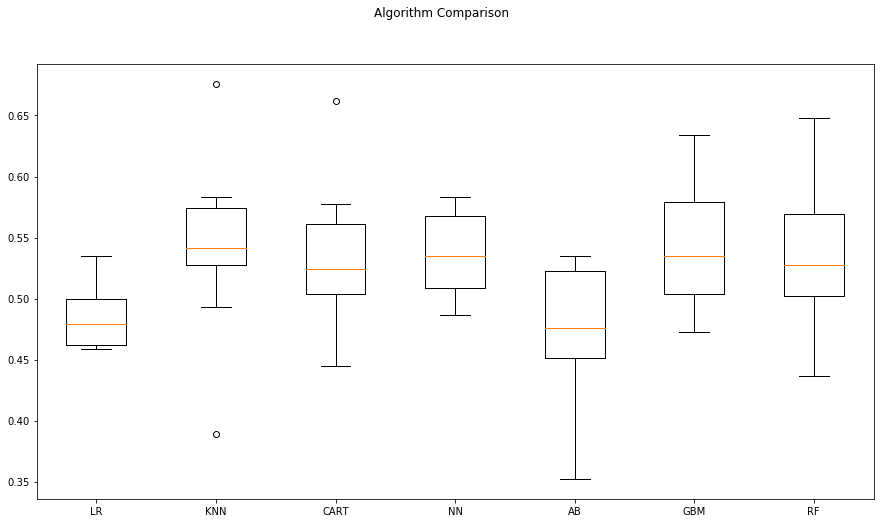

In [95]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## Hyper Parameter Tuning with Grid Search

In [97]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,40,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.554558 using {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.522477 (0.050449) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.522379 (0.037905) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 40}
#9 0.522164 (0.075813) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#10 0.517997 (0.068868) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#7 0.522281 (0.055969) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 40}
#2 0.534781 (0.071138) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#1 0.554558 (0.054266) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#4 0.524961 (0.088871) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 40}
#3 0.530556 (0.078373) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#10 0.517997 (0.068338) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#12 0.512441 (0.071448) with: 

## Run the trained model on the test dataset

In [99]:
# Setup the model based on the parameters suggested by Grid Search
model = RandomForestClassifier(criterion='entropy', n_estimators=20,max_depth=5) 
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=20)

In [101]:
# Accuracy metrics on the test set
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.4945054945054945
[[56 71]
 [67 79]]
              precision    recall  f1-score   support

         0.0       0.46      0.44      0.45       127
         1.0       0.53      0.54      0.53       146

    accuracy                           0.49       273
   macro avg       0.49      0.49      0.49       273
weighted avg       0.49      0.49      0.49       273



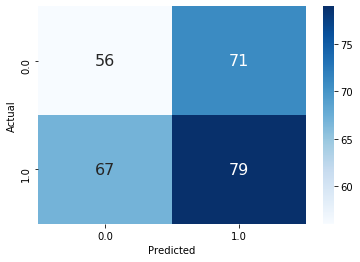

In [102]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}) # font size

## Feature importance

Text(0.5, 0, 'Variable Importance')

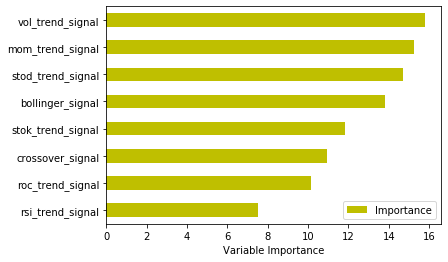

In [104]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y' )
plt.xlabel('Variable Importance')

In [105]:
######################################

In [106]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
2020-07-01 00:00:00-04:00,1.0,1.0
2020-07-02 00:00:00-04:00,1.0,1.0
2020-07-06 00:00:00-04:00,1.0,1.0
2020-07-07 00:00:00-04:00,1.0,1.0
2020-07-08 00:00:00-04:00,0.0,1.0
...,...,...
2021-07-26 00:00:00-04:00,1.0,1.0
2021-07-27 00:00:00-04:00,0.0,1.0
2021-07-28 00:00:00-04:00,1.0,1.0
2021-07-29 00:00:00-04:00,1.0,1.0
